In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix


2025-12-18 09:35:03.722033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766050503.944727      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766050504.008237      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
BASE_DIR = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR  = os.path.join(BASE_DIR, "test")

OUTPUT_DIR = "/kaggle/working/effnetb4"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = (384, 384)
BATCH_SIZE = 16

EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 20
EPOCHS_STAGE3 = 20


In [3]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.5
)


In [4]:
train_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_data = val_test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_data = val_test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=False
)

num_classes = train_data.num_classes
class_names = list(train_data.class_indices.keys())


Found 8144 images belonging to 196 classes.
Found 3977 images belonging to 196 classes.
Found 4064 images belonging to 196 classes.


Found 8144 images belonging to 196 classes.


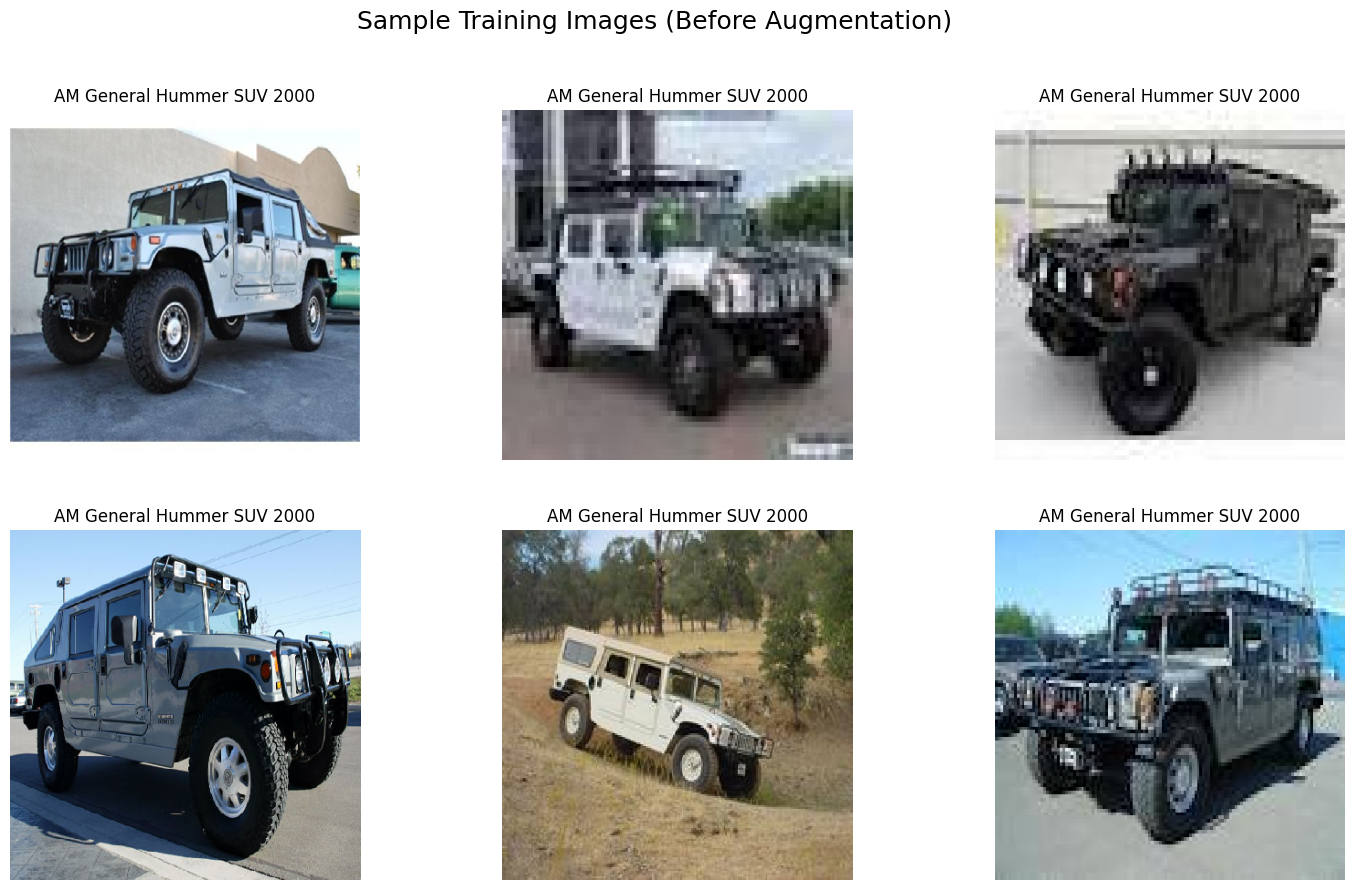

In [5]:
viz_gen = ImageDataGenerator()

viz_data = viz_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=6,
    class_mode="categorical",
    shuffle=False
)

images, labels = next(viz_data)

plt.figure(figsize=(18, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    class_idx = np.argmax(labels[i])
    plt.title(class_names[class_idx], fontsize=12)
    plt.axis("off")

plt.suptitle("Sample Training Images (Before Augmentation)", fontsize=18)
plt.show()


Found 8144 images belonging to 196 classes.


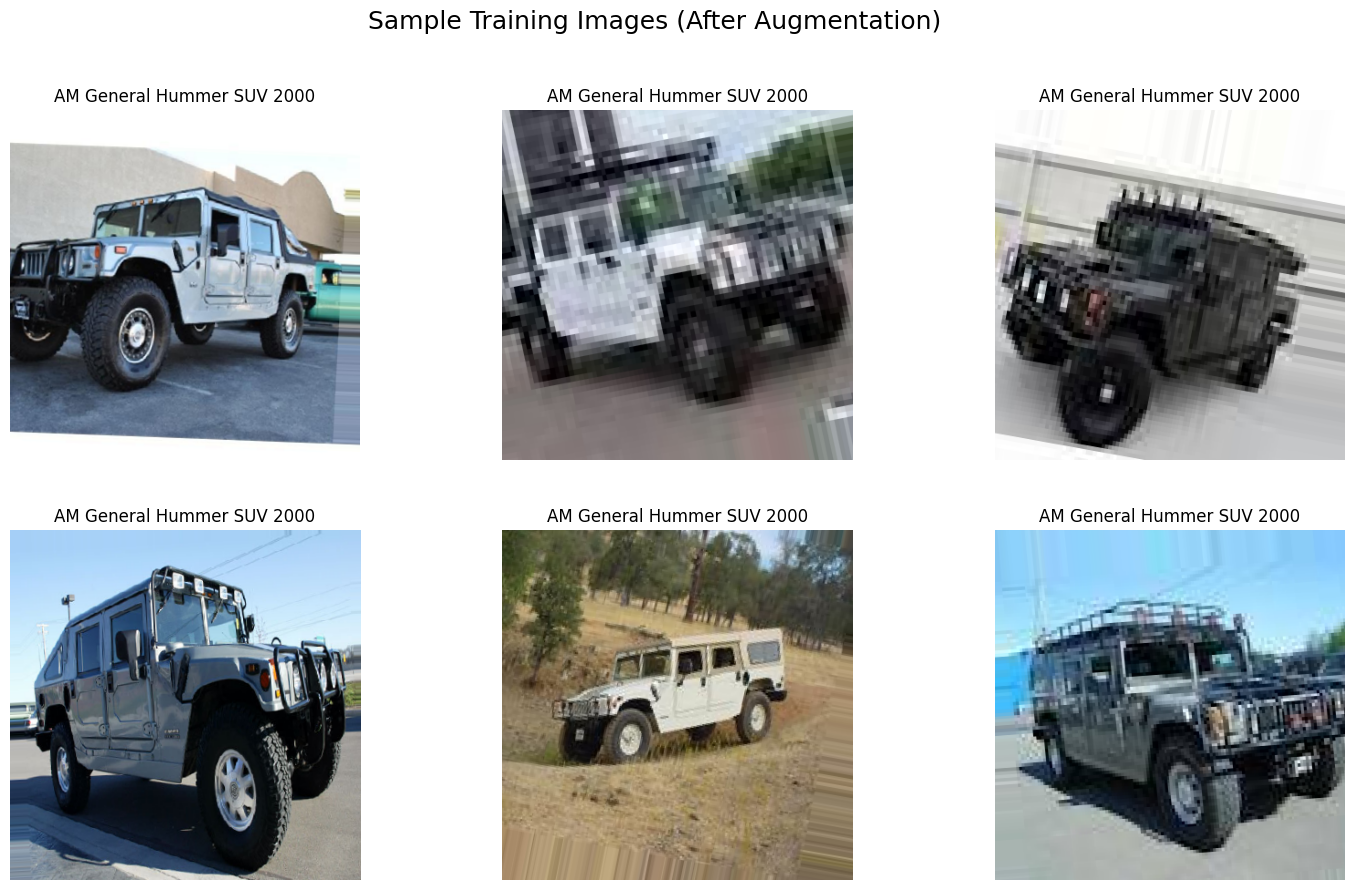

In [6]:
viz_aug_gen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

viz_aug_data = viz_aug_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=6,
    class_mode="categorical",
    shuffle=False
)

aug_images, aug_labels = next(viz_aug_data)

plt.figure(figsize=(18, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(aug_images[i].astype("uint8"))
    class_idx = np.argmax(aug_labels[i])
    plt.title(class_names[class_idx], fontsize=12)
    plt.axis("off")

plt.suptitle("Sample Training Images (After Augmentation)", fontsize=18)
plt.show()


In [7]:
base_model = EfficientNetB4(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(base_model.input, outputs)

model.compile(
    optimizer=Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)


I0000 00:00:1766050532.732702      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766050532.733289      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
checkpoint = ModelCheckpoint(
    os.path.join(OUTPUT_DIR, "best_model.keras"),
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    verbose=1
)


In [9]:
model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_STAGE1,
    callbacks=[checkpoint, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1766050558.041541     101 service.cc:148] XLA service 0x7d50cc022350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766050558.043060     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766050558.043080     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766050561.667463     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1766050566.443982     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766050566.624605     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/509 ━━━━━━━━━━━━━━━━━━━━ 6:01:06 43s/step - accuracy: 0.0000e+00 - loss: 6.9648

I0000 00:00:1766050580.963412     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.0707 - loss: 5.6198

E0000 00:00:1766050941.641744     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766050941.802963     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.24617, saving model to /kaggle/working/effnetb4/best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 410s 723ms/step - accuracy: 0.0708 - loss: 5.6188 - val_accuracy: 0.2462 - val_loss: 3.5955 - learning_rate: 0.0010
Epoch 2/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.1952 - loss: 4.1319
Epoch 2: val_accuracy improved from 0.24617 to 0.35479, saving model to /kaggle/working/effnetb4/best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 284s 558ms/step - accuracy: 0.1952 - loss: 4.1318 - val_accuracy: 0.3548 - val_loss: 3.0994 - learning_rate: 0.0010
Epoch 3/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.2770 - loss: 3.5959
Epoch 3: val_accuracy improved from 0.35479 to 0.40961, saving model to /kaggle/working/effnetb4/best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 285s 560ms/step - accuracy: 0.2770 - loss: 3.5959 - val_accuracy: 0.4096 - val_loss: 2.9410 - learning_rate: 0.0010
Epoch 4/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/

In [10]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_STAGE2,
    callbacks=[checkpoint, reduce_lr, early_stop]
)


Epoch 1/20


E0000 00:00:1766053534.354074     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766053534.506707     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766053534.754559     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766053534.907303     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766053535.340282     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.4624 - loss: 2.8243
Epoch 1: val_accuracy improved from 0.57430 to 0.67237, saving model to /kaggle/working/effnetb4/best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 349s 587ms/step - accuracy: 0.4626 - loss: 2.8237 - val_accuracy: 0.6724 - val_loss: 2.1485 - learning_rate: 1.0000e-04
Epoch 2/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.7148 - loss: 1.9733
Epoch 2: val_accuracy improved from 0.67237 to 0.72064, saving model to /kaggle/working/effnetb4/best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 284s 557ms/step - accuracy: 0.7148 - loss: 1.9732 - val_accuracy: 0.7206 - val_loss: 2.0273 - learning_rate: 1.0000e-04
Epoch 3/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7806 - loss: 1.7630
Epoch 3: val_accuracy improved from 0.72064 to 0.74026, saving model to /kaggle/working/effnetb4/best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 288s 566ms/step - accuracy: 0.7806 - loss: 1.7630 - val_accuracy: 0.7403 - val

In [11]:
base_model.trainable = True

model.compile(
    optimizer=Adam(1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_STAGE3,
    callbacks=[checkpoint, reduce_lr, early_stop]
)


Epoch 1/20


E0000 00:00:1766059404.678642     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766059404.824956     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766059405.231680     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766059405.377554     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766059405.843588     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.7564 - loss: 1.9020
Epoch 1: val_accuracy did not improve from 0.82499
509/509 ━━━━━━━━━━━━━━━━━━━━ 447s 623ms/step - accuracy: 0.7564 - loss: 1.9017 - val_accuracy: 0.7775 - val_loss: 1.7748 - learning_rate: 1.0000e-05
Epoch 2/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8721 - loss: 1.5075
Epoch 2: val_accuracy did not improve from 0.82499
509/509 ━━━━━━━━━━━━━━━━━━━━ 302s 591ms/step - accuracy: 0.8721 - loss: 1.5074 - val_accuracy: 0.8001 - val_loss: 1.6894 - learning_rate: 1.0000e-05
Epoch 3/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9319 - loss: 1.3452
Epoch 3: val_accuracy did not improve from 0.82499
509/509 ━━━━━━━━━━━━━━━━━━━━ 306s 601ms/step - accuracy: 0.9319 - loss: 1.3452 - val_accuracy: 0.8139 - val_loss: 1.6373 - learning_rate: 1.0000e-05
Epoch 4/20
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9411 - loss: 1.3063
Epoch 4: val_accuracy improved from 0.82499 to 0.82550, sav

In [12]:
model.load_weights(os.path.join(OUTPUT_DIR, "best_model.keras"))

preds = model.predict(test_data)
y_pred = np.argmax(preds, axis=1)
y_true = test_data.classes

print("EfficientNetB4 Test Accuracy:", np.mean(y_pred == y_true))

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


254/254 ━━━━━━━━━━━━━━━━━━━━ 87s 309ms/step
EfficientNetB4 Test Accuracy: 0.8703248031496063
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       1.00      0.95      0.98        22
                             Acura Integra Type R 2001       0.90      0.82      0.86        22
                                   Acura RL Sedan 2012       0.80      0.75      0.77        16
                                   Acura TL Sedan 2012       0.78      0.95      0.86        22
                                  Acura TL Type-S 2008       0.87      0.95      0.91        21
                                  Acura TSX Sedan 2012       0.83      0.75      0.79        20
                              Acura ZDX Hatchback 2012       0.89      0.80      0.84        20
              Aston Martin V8 Vantage Convertible 2012       0.73      0.83      0.78        23
                    Aston Martin V8 Vantag

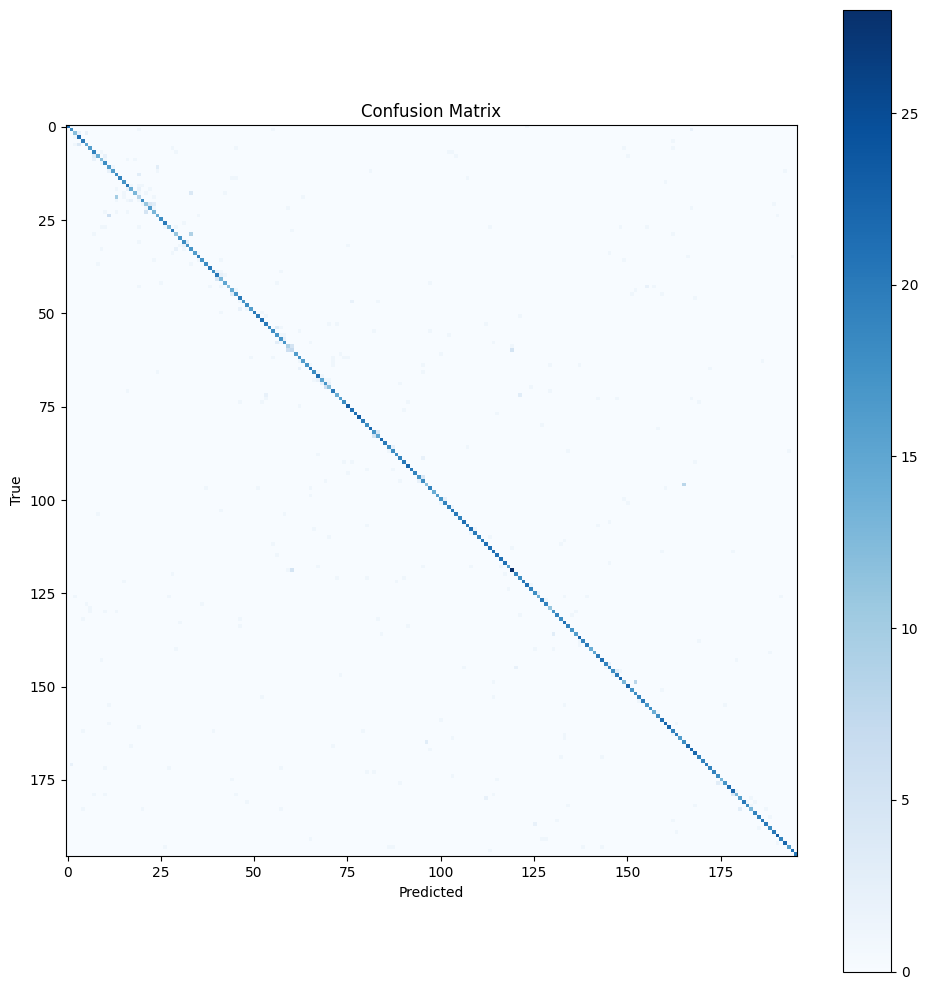

In [13]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
